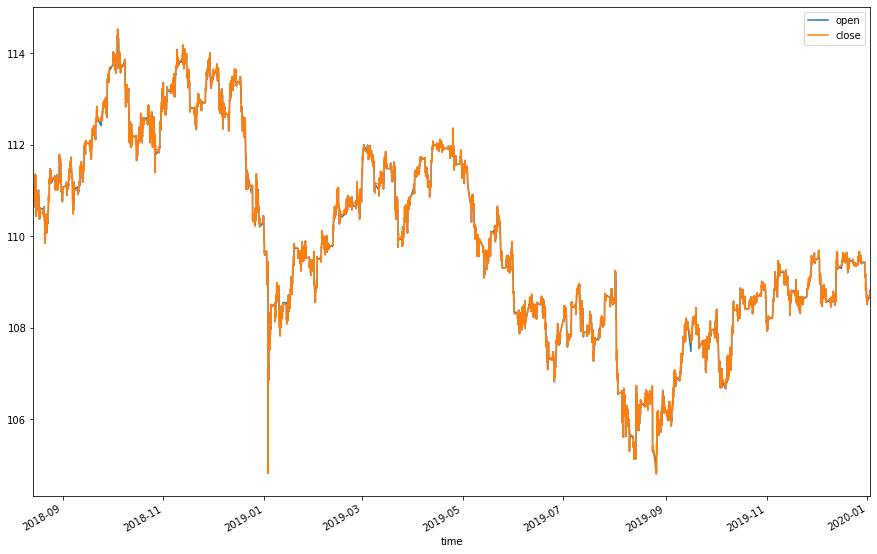

In [55]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib.pyplot import figure

df = pd.read_csv('2018-08-14_06_00_00_2020-01-02_19_00_00_H1.csv', index_col='time', parse_dates=True)
df.drop(columns=['complete'],inplace=True)
df.plot(y=['open','close'],figsize=(15,10));

In [56]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

df

,open,high,low,close,amount
time,,,,,
2018-08-14 06:00:00,110.687,110.766,110.636,110.744,924.0
2018-08-14 07:00:00,110.748,110.772,110.712,110.724,519.0
2018-08-14 08:00:00,110.722,110.724,110.602,110.631,524.0
2018-08-14 09:00:00,110.633,110.832,110.589,110.787,1425.0
2018-08-14 10:00:00,110.790,110.868,110.700,110.780,944.0
...,...,...,...,...,...
2020-01-02 15:00:00,108.744,108.750,108.712,108.712,107.0
2020-01-02 16:00:00,108.710,108.800,108.696,108.784,417.0
2020-01-02 17:00:00,108.782,108.820,108.766,108.780,561.0


In [57]:
periods = 8619
df.index = pd.date_range(start='2018-08-14 06:00:00',freq='H',periods=periods)
df.index

DatetimeIndex(['2018-08-14 06:00:00', '2018-08-14 07:00:00',
               '2018-08-14 08:00:00', '2018-08-14 09:00:00',
               '2018-08-14 10:00:00', '2018-08-14 11:00:00',
               '2018-08-14 12:00:00', '2018-08-14 13:00:00',
               '2018-08-14 14:00:00', '2018-08-14 15:00:00',
               ...
               '2019-08-07 23:00:00', '2019-08-08 00:00:00',
               '2019-08-08 01:00:00', '2019-08-08 02:00:00',
               '2019-08-08 03:00:00', '2019-08-08 04:00:00',
               '2019-08-08 05:00:00', '2019-08-08 06:00:00',
               '2019-08-08 07:00:00', '2019-08-08 08:00:00'],
              dtype='datetime64[ns]', length=8619, freq='H')

In [58]:
df = df[['open']]
df

,open
2018-08-14 06:00:00,110.687
2018-08-14 07:00:00,110.748
2018-08-14 08:00:00,110.722
2018-08-14 09:00:00,110.633
2018-08-14 10:00:00,110.790
...,...
2019-08-08 04:00:00,108.744
2019-08-08 05:00:00,108.710
2019-08-08 06:00:00,108.782
2019-08-08 07:00:00,108.783


In [59]:
import math
train = df.iloc[:math.ceil(periods*0.8)]
test = df.iloc[math.ceil(periods*0.8):]

In [60]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [61]:
auto_arima(df,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8619
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9228.398
Date:                Sat, 01 Feb 2020   AIC                         -18454.797
Time:                        01:17:53   BIC                         -18447.735
Sample:                             0   HQIC                        -18452.389
                               - 8619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0069   2.64e-05    260.022      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                       53.10   Jarque-Bera (JB):            310516.04
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
model = ARMA(train,order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   open   No. Observations:                 6896
Model:                     ARMA(2, 2)   Log Likelihood                7062.711
Method:                       css-mle   S.D. of innovations              0.087
Date:                Sat, 01 Feb 2020   AIC                         -14113.421
Time:                        01:17:54   BIC                         -14072.389
Sample:                    08-14-2018   HQIC                        -14099.272
                         - 05-28-2019                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        110.0112      1.115     98.688      0.000     107.826     112.196
ar.L1.open     1.1243      0.066     17.118      0.000       0.996       1.253
ar.L2.open    -0.1250      0.066     -1.905      0.057      -0.254       0.004
ma.L1.open    -0.1281      0.067     -1.922      0.055      -0.259       0.003
ma.L2.open    -0.0296      0.012     -2.498      0.013      -0.053      -0.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0008           +0.0000j            1.0008            0.0000
AR.2            7.9935           +0.0000j            7.9935            0.0000
MA.1            4.0405           +0.0000j            4.0405            0.0000
MA.2           -8.3727           +0.0000j            8.3727            0.5000
-----------------------------------------------------------------------------
"""

In [63]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

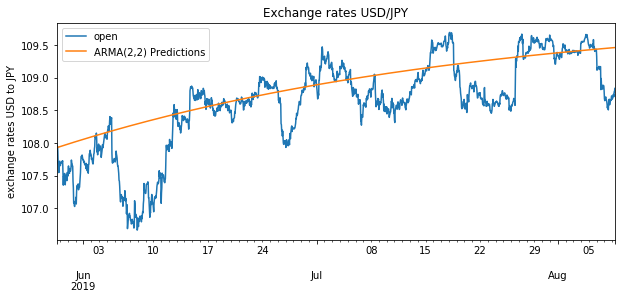

In [68]:
title = 'Exchange rates USD/JPY'
ylabel='exchange rates USD to JPY'
xlabel='' # we don't really need a label here

ax = test.plot(legend=True,figsize=(10,4),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

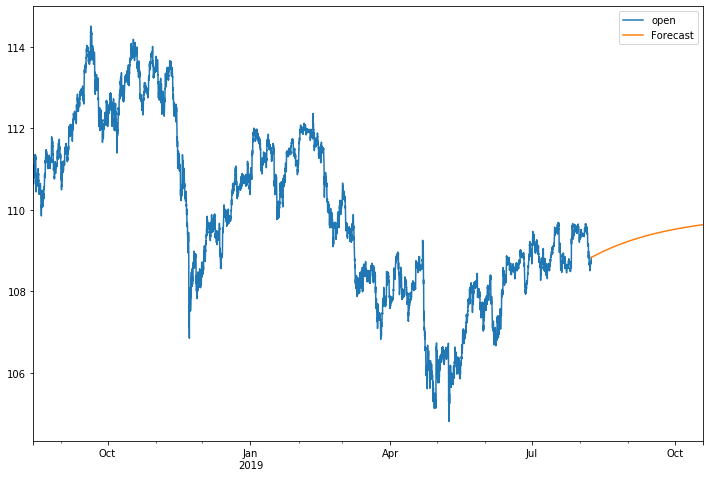

In [65]:
# First, retrain the model on the full dataset
model = ARMA(df['open'],order=(2,2))

# Next, fit the model
ARfit = model.fit(method='mle')

# Make predictions
fcast = ARfit.predict(start=len(df), end=len(df)+math.ceil(periods*0.2), dynamic=False).rename('Forecast')

# Plot the results
df['open'].plot(legend=True)
fcast.plot(legend=True,figsize=(12,8));

#ARIMA

In [44]:
auto_arima(df,seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8619
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9228.398
Date:                Sat, 01 Feb 2020   AIC                         -18454.797
Time:                        00:32:34   BIC                         -18447.735
Sample:                             0   HQIC                        -18452.389
                               - 8619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0069   2.64e-05    260.022      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                       53.10   Jarque-Bera (JB):            310516.04
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
# from statsmodels.tsa.statespace.tools import diff
# df = diff(df,k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

# adf_test(df,'Exchange Rates of USD/JPY')

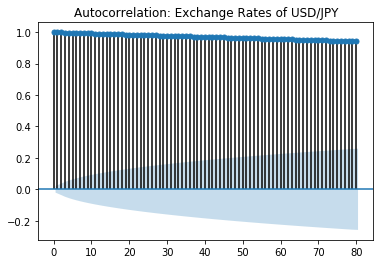

In [53]:
title = 'Autocorrelation: Exchange Rates of USD/JPY'
lags = 80
plot_acf(df,title=title,lags=lags);

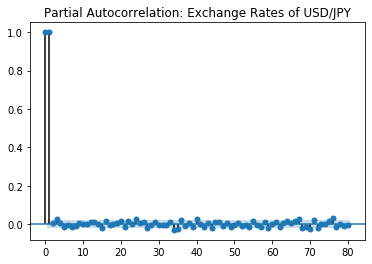

In [52]:
title = 'Partial Autocorrelation: Exchange Rates of USD/JPY'
lags = 80
plot_pacf(df,title=title,lags=lags);

In [20]:
stepwise_fit = auto_arima(df, start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-18452.855, BIC=-18438.732, Fit time=1.426 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-18451.165, BIC=-18429.980, Fit time=0.587 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=-18451.181, BIC=-18429.996, Fit time=2.088 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=-18454.797, BIC=-18447.735, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=-18450.623, BIC=-18422.377, Fit time=1.718 seconds
Total fit time: 6.172 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8619
Model:               SARIMAX(0, 1, 0)   Log Likelihood                9228.398
Date:                Fri, 31 Jan 2020   AIC                         -18454.797
Time:                        16:06:55   BIC                         -18447.735
Sample:                             0   HQIC                        -18452.389
                               - 8619                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0069   2.64e-05    260.022      0.000       0.007       0.007
===================================================================================
Ljung-Box (Q):                       53.10   Jarque-Bera (JB):            310516.04
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        32.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
model = ARIMA(train,order=(1,1,1))
results = model.fit()
results.summary()

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [ ]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test.iloc[i]}")

In [ ]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Plot predictions against known values
title = 'Exchange Rates of USD/JPY'
ylabel='Exchange Rates of USD/JPY'
xlabel='' # we don't really need a label here

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [ ]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

In [42]:
# from statsmodels.tools.eval_measures import rmse

# error = rmse(test, predictions)
# print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

In [49]:
model = ARIMA(df['open'],order=(1,1,1),enfo)
results = model.fit()
fcast = results.predict(len(df2),len(df2)+69408,typ='levels').rename('ARIMA(1,1,1) Forecast')

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [ ]:
# Plot predictions against known values
title = 'Exchange Rates of USD/JPY'
ylabel='Exchange Rates of USD/JPY'
xlabel='' # we don't really need a label here

ax = df.plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

In [48]:
df['open']

2019-01-28 09:01:00   -0.002
2019-01-28 09:02:00    0.012
2019-01-28 09:03:00   -0.004
2019-01-28 09:04:00    0.000
2019-01-28 09:05:00   -0.005
                       ...  
2019-09-26 08:58:00   -0.002
2019-09-26 08:59:00    0.004
2019-09-26 09:00:00    0.002
2019-09-26 09:01:00    0.000
2019-09-26 09:02:00   -0.008
Freq: T, Name: open, Length: 347042, dtype: float64